# Why the single-cavity equations do not work?

In [ ]:
using Revise

includet("../modules/OpticalCavity.jl")
includet("../modules/Thermodynamics.jl")
includet("../modules/MasterEquations.jl")
includet("../modules/Phaseonium.jl")
includet("../modules/BosonicOperators.jl")
includet("../modules/Measurements.jl")


using .OpticalCavity
using .Thermodynamics
using .MasterEquations
using .Phaseonium
using .BosonicOperators
using .Measurements



includet("./RoutineFunctions.jl")

: 

In [2]:
using MKL
using Revise
using Dates
using CSV
using DataFrames
using LinearAlgebra
using SparseArrays
using ProgressBars
using Plots
using LaTeXStrings
using TOML
# Saving the output matrix
using Serialization
using NPZ

includet("src/configurations_generation.jl")

In [12]:
CSV_FILE = "./simulations/simulations_ledger.csv";

csv = CSV.read(CSV_FILE, DataFrame, header=1);
dirs = ["simulations/simulation_$n" for n in csv[!, "meta_name"]]

# Remove all simulations and records on the csv after a certain index
for dir in dirs[130:end]
    rm(dir; force=true, recursive=true)
end

In [27]:
files_created, configurations = generate_configurations(config_file="fast_config.toml");


Simulations folder contains 187 simulations.
0 existing configurations were skipped.
5 new configurations will be added.


In [3]:
includet("src/main-iterator.jl")

Running a fast cycle to compile the file
Done.
New version created 2025-09-18T21:38:43.014
There are 154 simulation files.


---------------

Finished!!


In [ ]:
main_iterator()

New version created 2025-09-18T22:18:54.022
There are 192 simulation files.


_____________________________

Expanding Force: 1.0e-12
Compressing Force: 0.01
Cycle 1
Isochoric Stroke
State C2 = nothing
Simulation returned the error 'ErrorException("Cavity is almost still during Expansion with force 1.0e-12 and pressure 1.5638149515500718e-13")'.


_____________________________

Expanding Force: 1.0e-11
Compressing Force: 0.01
Cycle 1
Isochoric Stroke
State C2 = nothing
Simulation returned the error 'ErrorException("Cavity is almost still during Expansion with force 1.0e-11 and pressure 1.5638149515500718e-13")'.


_____________________________

Expanding Force: 1.0e-13
Compressing Force: 0.01
Cycle 1
Isochoric Stroke


In [29]:
force=1.0e-14
p1 = 1.5638149515500718e-13
surface = 100000
a1 = (p1 * surface - force)

1.5638139515500717e-8

In [33]:
# Remove report.txt from folder to make the simulation run again
for dir in files_created
    isfile(dir * "/report.txt") && rm(dir * "/report.txt")
end

In [18]:
files_created = "ff96ce52-9,9e6075fa-0,c43f6992-3,2c6da2a0-9,a3a6bea9-6,239392df-4,029d80aa-6,efe00a3a-1,83255a08-a,b71d261b-e,da132dd0-c,75878ef4-c,61f6a334-4,32dd7bb9-8,26282ce8-3,ee878e94-8,03e35545-2,a67ed75e-8,30d4e21f-f,37971498-a,1527b7fc-9,b6cf08f9-6,44a66a7c-e,2a598f66-b,bee09e84-6"
files_created = ["simulations/simulation_$f" for f in split(files_created, ",")]

25-element Vector{String}:
 "simulations/simulation_ff96ce52-9"
 "simulations/simulation_9e6075fa-0"
 "simulations/simulation_c43f6992-3"
 "simulations/simulation_2c6da2a0-9"
 "simulations/simulation_a3a6bea9-6"
 "simulations/simulation_239392df-4"
 "simulations/simulation_029d80aa-6"
 "simulations/simulation_efe00a3a-1"
 "simulations/simulation_83255a08-a"
 "simulations/simulation_b71d261b-e"
 ⋮
 "simulations/simulation_03e35545-2"
 "simulations/simulation_a67ed75e-8"
 "simulations/simulation_30d4e21f-f"
 "simulations/simulation_37971498-a"
 "simulations/simulation_1527b7fc-9"
 "simulations/simulation_b6cf08f9-6"
 "simulations/simulation_44a66a7c-e"
 "simulations/simulation_2a598f66-b"
 "simulations/simulation_bee09e84-6"

In [ ]:
function _check(ρ)
    println("System after the stroke:")
    println(checkdensity(ρ))
    println("Final Temperature of the System: $(Measurements.temperature(ρ, ω))")
end

function plot_stroke_state(system_evolution, cavity_evolution, α0)
    temperatures = []
    entropies = []
    for (i, ρ) in enumerate(system_evolution)
        local ω = α0 / cavity_evolution[i]
        t = Measurements.temperature(ρ, ω)
        ent = Measurements.entropy_vn(ρ)
        
        push!(temperatures, t)
        push!(entropies, ent)
    end

    g = plot(entropies, temperatures, label="Stroke")
    # Plot starting point
    scatter!(g, [entropies[1]], [temperatures[1]], label="Start", mc="blue", ms=5)
    # Plot ending point
    scatter!(g, [entropies[end]], [temperatures[end]], label="End", mc="red", ms=5)
    title!("Phaseonium Stroke (Isochoric)")
    xlabel!("Entropy")
    ylabel!("Temperature")
    display(g)
end


function plot_temperature(system_evolution, cavity_evolution, α0)    
    temperatures = []
    for (i, ρ) in enumerate(system_evolution)
        local ω = α0 / cavity_evolution[i]
        t = Measurements.temperature(ρ, ω)
        
        push!(temperatures, t)
    end

    g = plot(temperatures, label="Temperature")
    title!("Temperature Evolution")
    xlabel!("Time")
    ylabel!("Temperature")

    return g
end

plot_temperature (generic function with 1 method)

In [ ]:
function cascade_evolution(thermalizationtime, ρt, α0, bosonic_operators, ga, gb)
    # system_evolution, cavity_evolution = Thermodynamics.adiabatic_stroke(
    #     ρt, thermalizationtime, Δt, [a, ad], cavity; sampling_each=10)
    system_evolution = Thermodynamics.phaseonium_stroke_2(
        ρt, thermalizationtime, bosonic_operators, ga, gb; sampling_steps=50, verbose=3)

    return system_evolution
end


function onesystem_evolution(thermalizationtime, ρt, α0, bosonic_operators, ga, gb)
    # system_evolution, cavity_evolution = Thermodynamics.adiabatic_stroke(
    #     ρt, thermalizationtime, Δt, [a, ad], cavity; sampling_each=10)
    system_evolution = Thermodynamics.phaseonium_stroke(
        ρt, thermalizationtime, bosonic_operators, [ga, gb]; sampling_steps=50, verbose=3)

    return system_evolution
end

In [ ]:
function main(systems, thermalizationtime)
    ndims = 25
    Ω = 1.0
    Δt = 1e-2

    T_initial = 0.01
    T_final = 0.08

    # Create a Cavity
    α0 = 2*π
    l0 = 50000.0
    cavity = Cavity(1.0, 10000.0, l0, α0, 0, 0.05)
    ω = α0 / l0

    global ρt = thermalstate(ndims, ω, T_initial)

    # Create Phaseonium atoms
    ϕ = π/1.8
    α = Phaseonium.alpha_from_temperature(T_final, ϕ, ω)
    println("Phaseonium α: $α < $(sqrt((1+cos(ϕ))/(3+cos(ϕ))))")

    η = Phaseonium.densitymatrix(α, ϕ)

    ga, gb = Phaseonium.dissipationrates(α, ϕ)
    final_temperature = Phaseonium.finaltemperature(ω, ga, gb)
    println(
        "Apparent Temperature carried by Phaseonium atoms: 
        $(final_temperature)")

    # Define Kraus Operators
    identity_op = I(ndims)
    a = BosonicOperators.destroy(ndims)
    ad = BosonicOperators.create(ndims)

    C = BosonicOperators.C(Ω*Δt, ndims)
    Cp = BosonicOperators.Cp(Ω*Δt, ndims)
    S = BosonicOperators.S(Ω*Δt, ndims)
    Sd = BosonicOperators.Sd(Ω*Δt, ndims)

    E0 = sqrt(1 - ga/2 - gb/2) * identity(ndims)
    E1 = sqrt(ga/2) * C
    E2 = sqrt(ga) * S
    E3 = sqrt(gb/2) * Cp
    E4 = sqrt(gb) * Sd

    kraus = [E0, E1, E2, E3, E4]

    if systems == 1
        println("One system evolution")
        system_evolution = onesystem_evolution(thermalizationtime, ρt, α0, [C, Cp, S, Sd], ga, gb)
        figname = "phaseonium_stroke.png"
    else
        println("Cascade evolution")
        ρt = Matrix(kron(ρt, ρt))
        system_evolution = cascade_evolution(thermalizationtime, ρt, α0, [C, Cp, S, Sd], ga, gb)
        figname = "phaseonium_stroke_cascade.png"
    end

    cavity_evolution = [cavity.length for _ in 1:length(system_evolution)]

    g = plot_temperature(system_evolution, cavity_evolution, α0)
    times = range(1, length(system_evolution))
    γ = ga / gb
    # Thermalization function
    f(x, γ) = (final_temperature - T_initial) * (1 - exp(-γ * (x - 1))) + T_initial
    #plot!(g, times, f.(times, γ), label="Theoretical Temperature", lc=:red)
    display(g)
    savefig(g, figname)

    return system_evolution
    
end

main (generic function with 1 method)

Phaseonium α: 0.5404157047553073 < 0.5407162030609368
Apparent Temperature carried by Phaseonium atoms: 
        0.07999999999998483
Cascade evolution
nothingIsochoric Stroke


0.0%┣                                               ┫ 0/49 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/49 [02:22<Inf:Inf, InfGs/it]
4.1%┣█▊                                         ┫ 2/49 [04:43<03:41:22, 283s/it]
6.1%┣██▋                                        ┫ 3/49 [07:03<02:42:20, 212s/it]
8.2%┣███▌                                       ┫ 4/49 [09:21<02:20:16, 187s/it]
10.2%┣████▎                                     ┫ 5/49 [11:42<02:08:38, 175s/it]
12.2%┣█████▏                                    ┫ 6/49 [14:03<02:00:52, 169s/it]
14.3%┣██████                                    ┫ 7/49 [16:24<01:54:50, 164s/it]
16.3%┣██████▉                                   ┫ 8/49 [18:44<01:49:46, 161s/it]
18.4%┣███████▊                                  ┫ 9/49 [21:04<01:45:19, 158s/it]
20.4%┣████████▍                                ┫ 10/49 [23:23<01:41:21, 156s/it]
22.4%┣█████████▏                               ┫ 11/49 [25:43<01:37:42, 154s/it]
24.5%┣██████████            

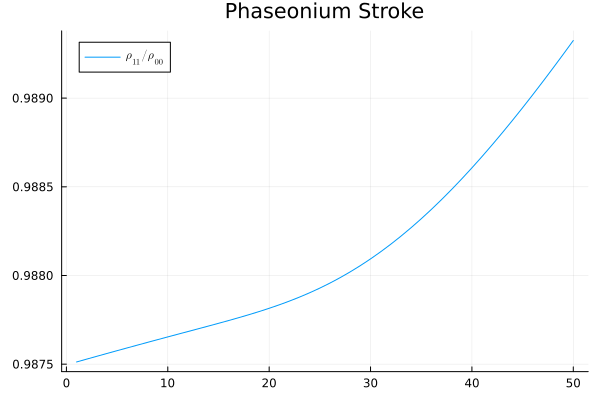

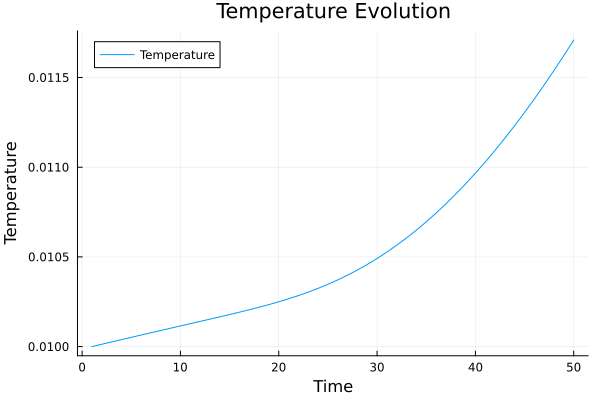

50-element Vector{Matrix{Float64}}:
 [0.00214554106870519 0.0 … 0.0 0.0; 0.0 0.0021187481022212386 … 0.0 0.0; … ; 0.0 0.0 … 0.0011885954883545423 0.0; 0.0 0.0 … 0.0 0.0011737526127988311]
 [0.002140075409333803 0.0 … 0.0 0.0; 0.0 0.002113385085995701 … 0.0 0.0; … ; 0.0 0.0 … 0.0012163533166353149 0.0; 0.0 0.0 … 0.0 0.0012103825676619817]
 [0.0021346398496040193 0.0 … 0.0 0.0; 0.0 0.0021080514179218474 … 0.0 0.0; … ; 0.0 0.0 … 0.0012343363606095838 0.0; 0.0 0.0 … 0.0 0.0012296437539491836]
 [0.002129234139912879 0.0 … 0.0 0.0; 0.0 0.002102746856189343 … 0.0 0.0; … ; 0.0 0.0 … 0.0012483804302157147 0.0; 0.0 0.0 … 0.0 0.0012442907669890121]
 [0.0021238580334286303 0.0 … 0.0 0.0; 0.0 0.0020974711616554686 … 0.0 0.0; … ; 0.0 0.0 … 0.001260205790343698 0.0; 0.0 0.0 … 0.0 0.001256492790594092]
 [0.002118511286053023 0.0 … 0.0 0.0; 0.0 0.0020922240978205587 … 0.0 0.0; … ; 0.0 0.0 … 0.0012705556206815062 0.0; 0.0 0.0 … 0.0 0.0012671105513434643]
 [0.0021131936563955765 0.0 … 0.0 0.0; 0.0 0.0020

In [ ]:
main(2, 100_000)